# Neural similarity

In [87]:
import sys
import os

import torch
import torch.nn as nn
import torchvision.models as models
import pandas as pd
import numpy as np

import cv2
import matplotlib.pyplot as plt

FOOD101_CLASSES = 101

def fix_names(state_dict):
    state_dict = {key.replace('module.', ''): value for (key, value) in state_dict.items()}
    return state_dict

model = models.mobilenet_v2(num_classes=FOOD101_CLASSES)  
checkpoint_path = 'mobilenet_v2_food101/pytorch_model.bin'

if os.path.isfile(checkpoint_path):
    print("=> loading checkpoint '{}'".format(checkpoint_path))
    

    checkpoint = torch.load(checkpoint_path, map_location=torch.device('cpu'))
    weights = fix_names(checkpoint['state_dict'])
    model.load_state_dict(weights)

    print("=> loaded checkpoint '{}' (epoch {})"
            .format(checkpoint_path, checkpoint['epoch']))

=> loading checkpoint 'mobilenet_v2_food101/pytorch_model.bin'
=> loaded checkpoint 'mobilenet_v2_food101/pytorch_model.bin' (epoch 27)


In [2]:
import torchvision
from torchvision import models, transforms, datasets

test_dataset = datasets.Food101(
        root='data/train',
        split = 'test'
    )
train_dataset = datasets.Food101(
        root='data/train',
        split = 'train',
    )

In [3]:
model.eval()

# Get the output of the last hidden layer
last_hidden_layer_output = None
def hook(module, input, output):
    global last_hidden_layer_output
    x = nn.functional.adaptive_avg_pool2d(output, (1, 1))
    last_hidden_layer_output = torch.flatten(x, 1)


In [4]:
data = pd.read_csv('final.csv')

In [23]:
data.shape

(75750, 1283)

In [6]:
def get_image_features(img):
    normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                  std=[0.229, 0.224, 0.225])
    transform = transforms.Compose([
            transforms.Resize(256),
            transforms.CenterCrop(224),
            transforms.ToTensor(),
            normalize,
        ])
    img = transform(img)
    hook_handle = model.features.register_forward_hook(hook)
    with torch.no_grad():
        res = model(img.unsqueeze(0))
    # Detach the hook
    hook_handle.remove()
    return last_hidden_layer_output[0]

In [7]:
# Create annoy for nearest neighbour
from annoy import AnnoyIndex
import random

f = 1280  # Length of item vector that will be indexed

t = AnnoyIndex(f, 'angular')
for _,x in data.iterrows():
    vals = x.values[1:1281]
    t.add_item(int(x['index']), vals)

t.build(100) # 10 trees
t.save('test.ann')



True

In [8]:
u = AnnoyIndex(f, 'angular')
u.load('test.ann') # super fast, will just mmap the file

True

In [9]:
def get_image_nearest(img,ann,n=5):
    features = get_image_features(img)
    values = data.values[:,1:1281].shape
    res = ann.get_nns_by_vector(features,n=n,include_distances=True)

    return res

In [82]:
idx = 1488  #interesting examples: 1488, 107 (missclass), 
index,distances = get_image_nearest(test_dataset[idx][0],u)

In [83]:
data[data.index.isin(index)]['correct']

17203     1
35543    50
38861    57
50650    42
67191    56
Name: correct, dtype: int64

Class: churros, 23


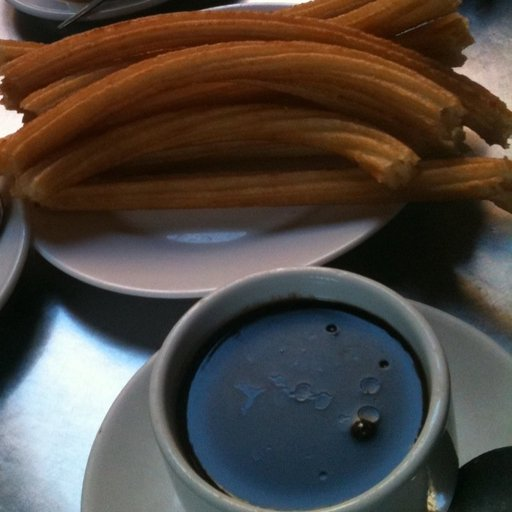

In [79]:
print(f"Class: {train_dataset.classes[test_dataset[idx][1]]}, {test_dataset[idx][1]}")
test_dataset[idx][0]


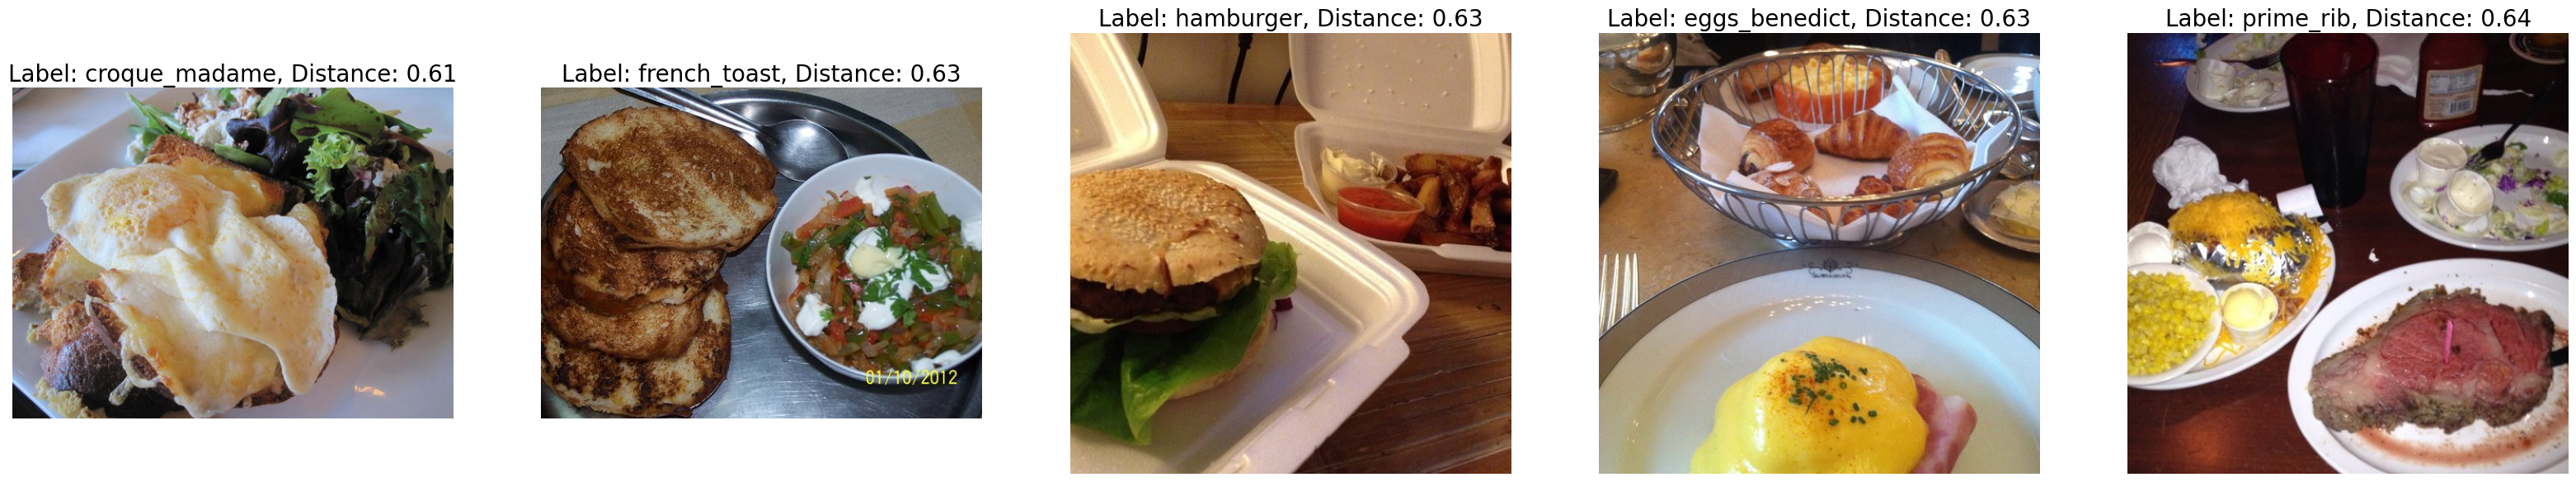

In [76]:
plt.figure(figsize=(40, 8))

for i, idx_train in enumerate(data[data.index.isin(index)].index):
    image, label = train_dataset[idx_train]  # Assuming 'dataset' is your torchvision.datasets object
    
    # Convert the tensor image to a PIL image and display it
    plt.subplot(1, 5, i + 1)  
    plt.imshow(image)  
    plt.title(f'Label: {train_dataset.classes[label]}, Distance: {round(distances[i], 2)}', fontsize=20)  
    plt.axis('off') 

plt.show()

# SIFT 

In [190]:
def calculate_sift_similarity(img1, img2, similarity_ratio = 0.8):
  
    img1, _ = img1
    img2, _ = img2

    img1 = np.array(img1)
    img2 = np.array(img2)
    gray1 = cv2.cvtColor(img1, cv2.COLOR_RGB2GRAY)
    gray2 = cv2.cvtColor(img2, cv2.COLOR_RGB2GRAY)

    sift = cv2.SIFT_create()

    kp1, des1 = sift.detectAndCompute(gray1, None)
    kp2, des2 = sift.detectAndCompute(gray2, None)

    bf = cv2.BFMatcher(normType=cv2.NORM_L2)
    matches = bf.knnMatch(des1, des2, k=2)

    good = []
    for m, n in matches:
        if m.distance < similarity_ratio * n.distance: 
            good.append([m])

    similarity_score = len(good) / np.min([len(des1), len(des2)])   #впливає дуже сильно те, як порахувати знаменник

    return similarity_score

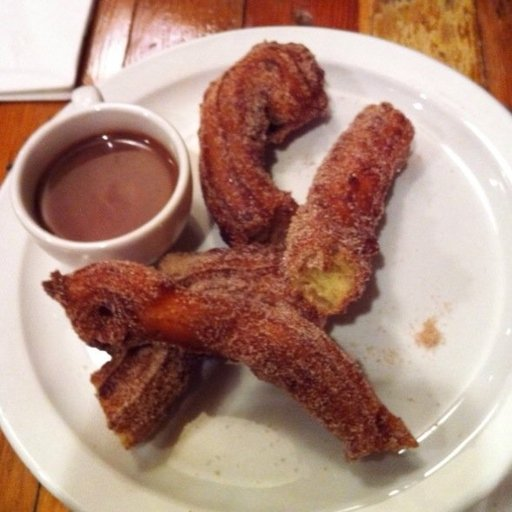

In [191]:
train_dataset[0][0]

In [192]:
calculate_sift_similarity(train_dataset[0], train_dataset[0])

1.0

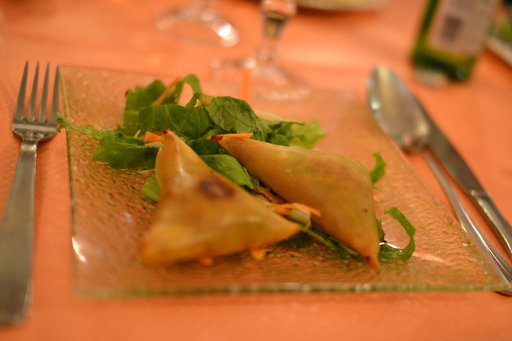

In [193]:
train_dataset[2034][0]

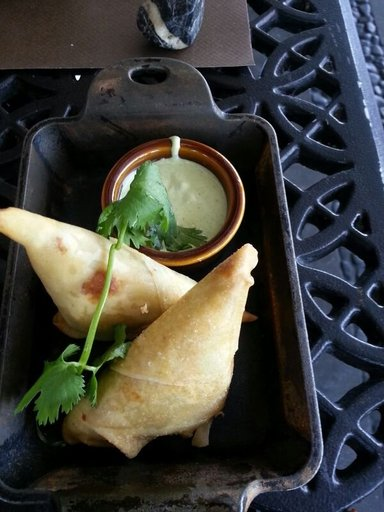

In [194]:
train_dataset[2021][0]

In [196]:
calculate_sift_similarity(train_dataset[2021], train_dataset[2034])

0.08779761904761904

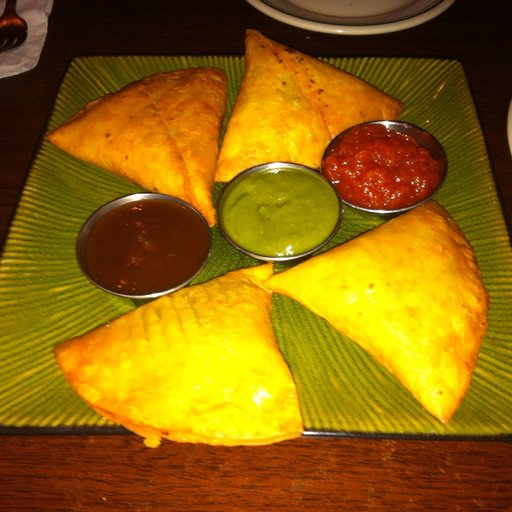

In [197]:
train_dataset[2039][0]

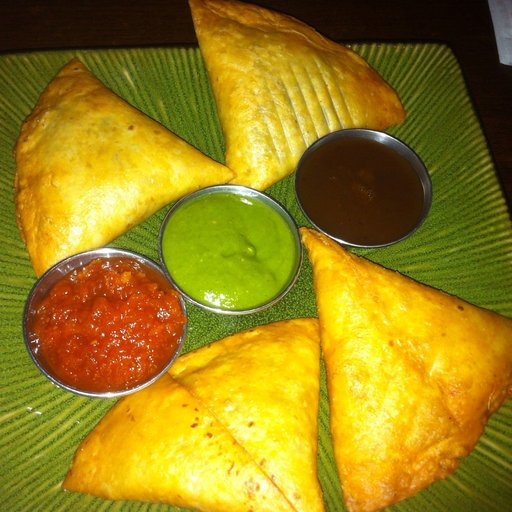

In [198]:
train_dataset[2035][0]

In [199]:
calculate_sift_similarity(train_dataset[2035], train_dataset[2039])

0.07557251908396946

In [200]:
calculate_sift_similarity(train_dataset[0], train_dataset[2039])

0.023923444976076555